# Air Passengers Forecasting

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

from darts.utils.statistics import plot_acf, plot_pacf, plot_hist, plot_residuals_analysis, check_seasonality, seasonal_decompose
from darts.metrics import mae, mape, mase, r2_score
from darts.models import (
    NaiveDrift,
    NaiveSeasonal,
    ARIMA,
    AutoARIMA,
    ExponentialSmoothing,
    Prophet,
    Theta
)
from darts

import warnings
warnings.filterwarnings('ignore')

In [106]:
def eval_darts_model(
    model,
    ts,
    val,
    error_functions,
):
    """Evaluates our darts model based on the metric provided
    
    :param model: Model to evaluate
    :param ts: TimeSeries object with the data to train our model
    :parma val: Dataset to evaluate our model
    :param error_function: Function to evaluate upon
    :return: Value of the error
    """
    model.fit(ts)
    prediction = model.predict(len(val))
    for error_function in error_functions:
        error = error_function(val, prediction)
        print(f"The error of the model {model} is: {error}")
        
    return error

In [2]:
airpassengers = AirPassengersDataset().load()

In [6]:
train, test = airpassengers.split_before(pd.Timestamp('19590101'))

## Data Description

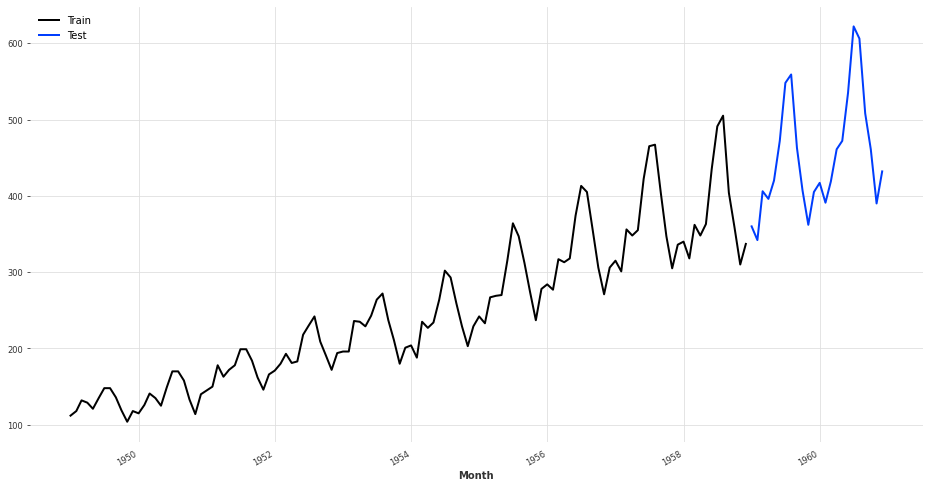

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
train.plot(label='Train')
test.plot(label='Test')

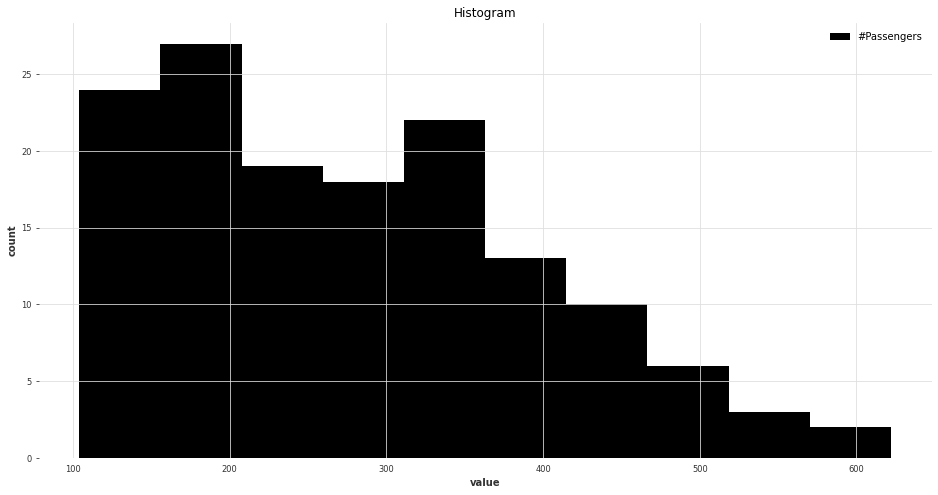

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_hist(airpassengers, ax=ax)

In [18]:
for i in range(2, 13):
    is_seasonal, s = check_seasonality(airpassengers, m=i)
    if is_seasonal:
        print(f"Seasonality of degree {s} found!")

Seasonality of degree 12 found!


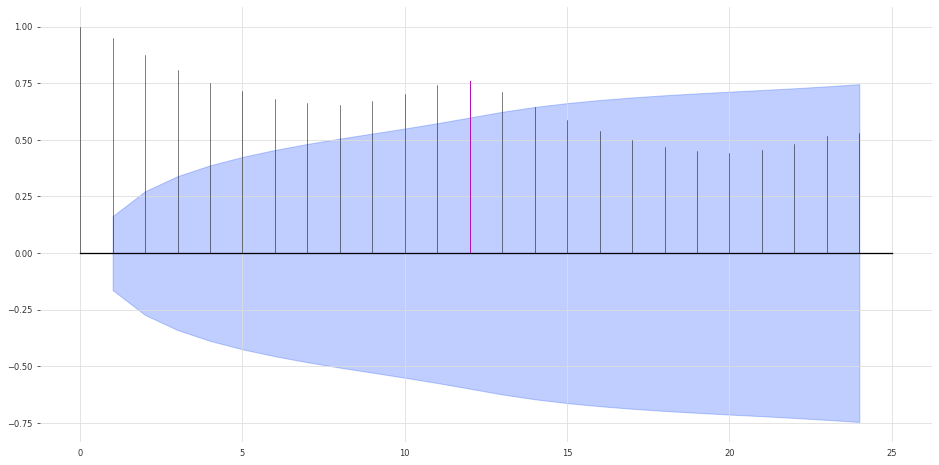

In [20]:
plot_acf(airpassengers, m=12, fig_size=(16, 8))

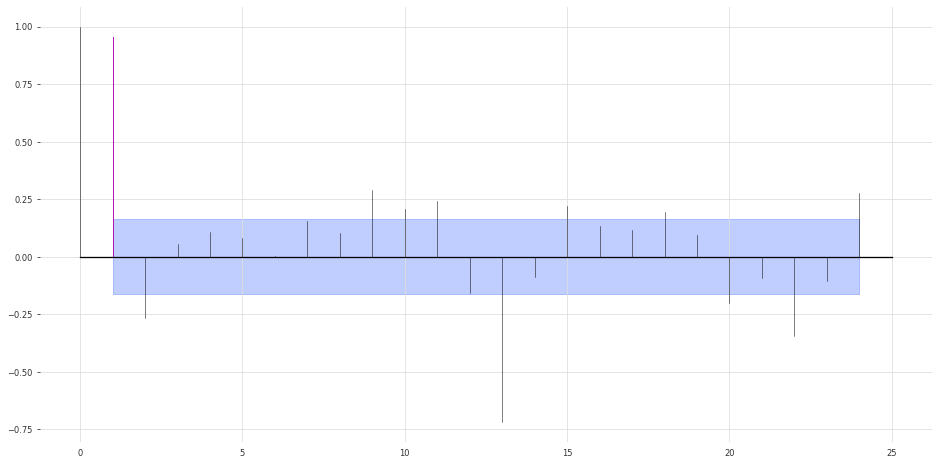

In [23]:
plot_pacf(airpassengers, m=1, fig_size=(16, 8))

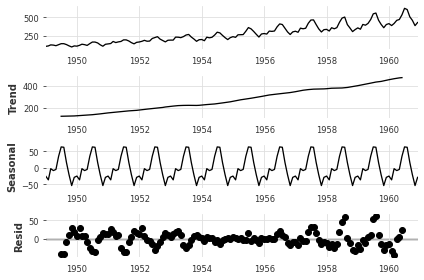

In [78]:
seasonal = seasonal_decompose(airpassengers.pd_dataframe())
_ = seasonal.plot()

## Modellling 

In [135]:
theta_grid = {
    'theta': range(1, 15, 1),
    'seasonality_period': [12]
}

theta_model = Theta.gridsearch(
    parameters= theta_grid, 
    series=train,
    forecast_horizon=12
)[0]

[2021-11-19 21:22:04,450] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'theta': 14, 'seasonality_period': 12}
[2021-11-19 21:22:04,450] INFO | darts.models.forecasting.forecasting_model | Chosen parameters: {'theta': 14, 'seasonality_period': 12}
INFO:darts.models.forecasting.forecasting_model:Chosen parameters: {'theta': 14, 'seasonality_period': 12}


In [146]:
models = (
    NaiveDrift(),
    NaiveSeasonal(K=12),
    AutoARIMA(),
    ExponentialSmoothing(seasonal_periods=12),
    Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True
    ),
    theta_model
)   

In [147]:
best_model = None
initial_error = np.inf

for model in models:
    backtest_errors = model.backtest(
        train, start=0.5, stride=6, forecast_horizon=12, metric=mape
    )
    model_error = np.mean(backtest_errors)
    print(model, ':', model_error)
    
    if model_error < initial_error:
        best_model = model

Naive drift model : 15.852470744501066
Naive seasonal model, with K=12 : 11.314696644758254
Auto-ARIMA : 13.52637676111049
Exponential smoothing : 6.331321686002955
Prophet : 7.171656390861231
Theta(14) : 4.998382291697072


## Evaluating

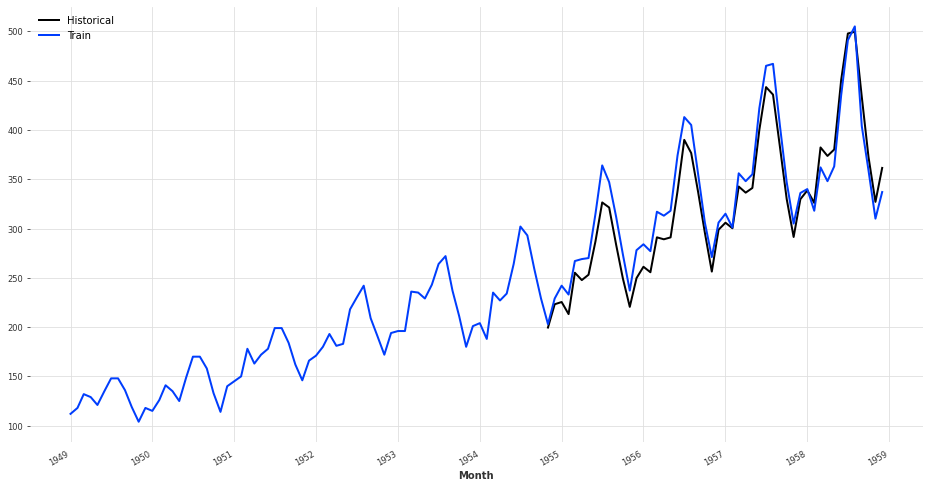

In [148]:
fig, ax = plt.subplots(figsize=(16, 8))
best_model.historical_forecasts(train, forecast_horizon=12).plot(label='Historical')
train.plot(label='Train')

## Prediction

In [174]:
best_model.fit(train)
pred = best_model.predict(len(test))

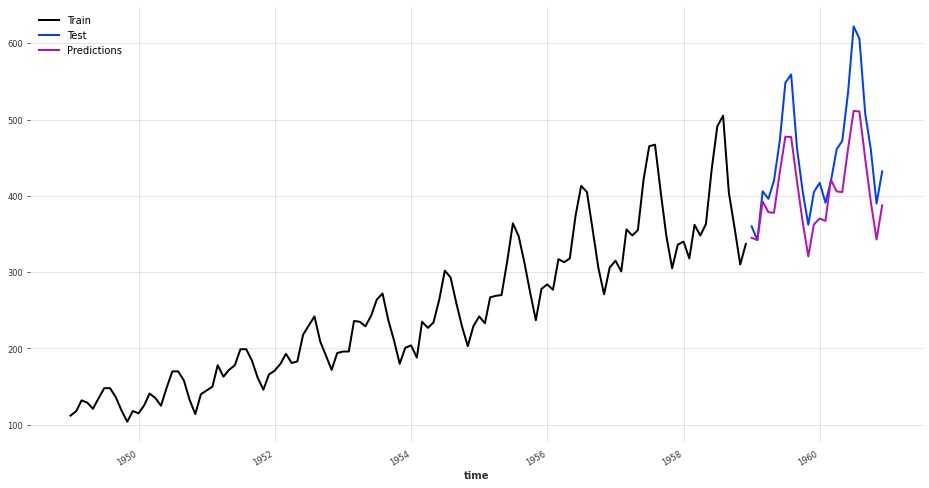

In [175]:
fig, ax = plt.subplots(figsize=(16, 8))
train.plot(label='Train')
test.plot(label='Test')
pred.plot(label='Predictions')

## Diagnosis

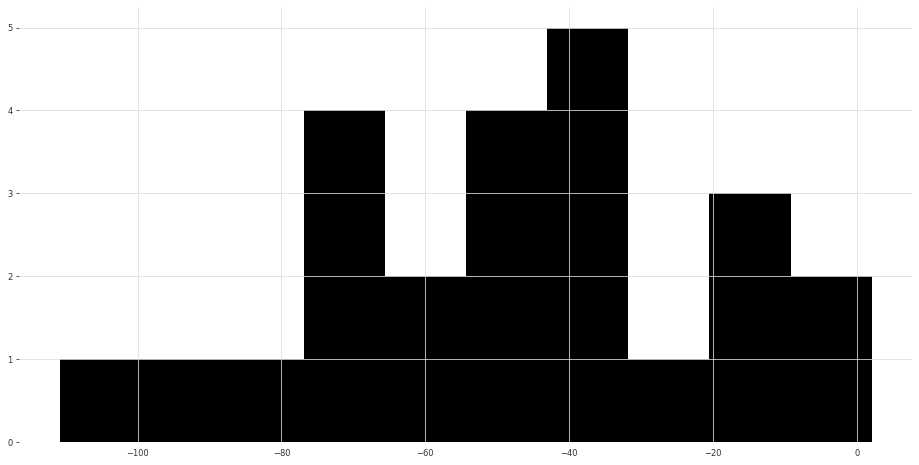

In [179]:
fig, ax = plt.subplots(figsize=(16, 8))
residuals = pred - test
residuals.pd_series().hist()
plt.show()

In [182]:
res_mean = np.mean(residuals.pd_series())
pred -= res_mean

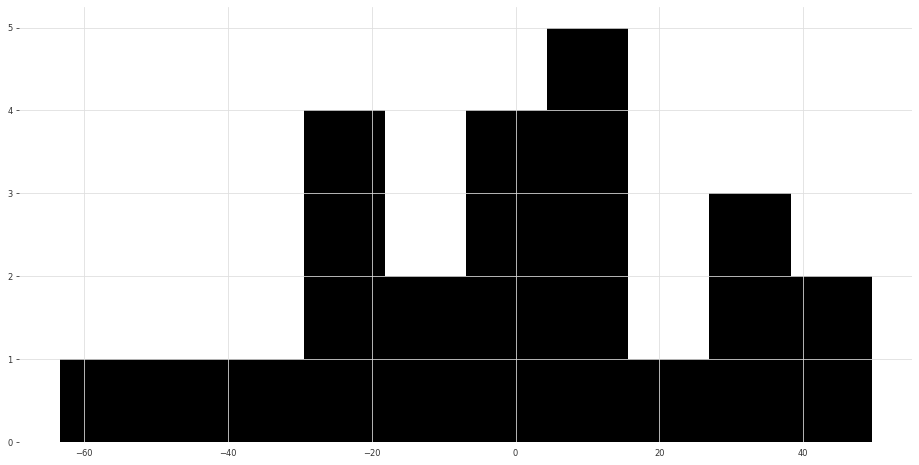

In [183]:
fig, ax = plt.subplots(figsize=(16, 8))
residuals = pred - test
residuals.pd_series().hist()
plt.show()

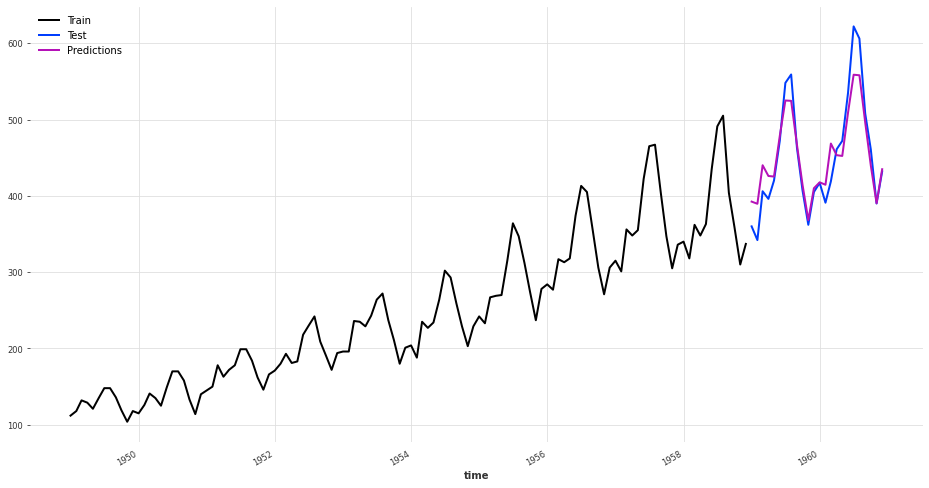

In [186]:
fig, ax = plt.subplots(figsize=(16, 8))
train.plot(label='Train')
test.plot(label='Test')
pred.plot(label='Predictions')

## Conclusions